In [1]:
import csv
import cv2
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.preprocessing import image as keras_image

from random import uniform
from random import randint

Using TensorFlow backend.


In [2]:
# Funtions for data augmentation for the second track

def random_shadow(image, bright=uniform(0.2,1.0)):
    """
    Generate from 1 to 10 shadows in the image.
    :param image: image to modify
    :param bright: The bright of the shadows. If not it is generated randomly. 
    :return: Modified image
    """ 
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    n_shadows=randint(1,10) 
    
    for i in np.arange(1,n_shadows):
        x_ini = randint(0, hls.shape[1])
        y_ini = randint(0, hls.shape[0])
        x_fin = randint(x_ini,x_ini+hls.shape[1])
        y_fin = randint(y_ini,y_ini+int(hls.shape[0]/4))
        hls[y_ini:y_fin,x_ini:x_fin,1] = hls[y_ini:y_fin,x_ini:x_fin,1]*bright

    image = cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)
        
    return image


def random_brightness(image, bright=uniform(0.3,1.0)):  
    """
    Modify the brightness of the image.
    :param image: image to modify
    :param bright: Brightness. If not it is generated randomly. 
    :return: Modified image
    """ 
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
       
    hls[:,:,1] = hls[:,:,1]*bright
    
    image = cv2.cvtColor(hls, cv2.COLOR_HLS2RGB)
    
    return image

In [3]:
# Funtions to extract data from the records of the simulator


def extractFilesFromCsv(csv_path, lateralCams=True, correction=0.6):
    """
    Read the .csv file and extract the path of all the files.
    :param csv_path: path of the .csv file
    :param lateralCams: If true lateral cams images ar procesed
    :param correction: angle correction for lateral cams
    :return: A table with the paths of the files and their values: angle, throtlee
    """ 
    table=[]
    with open(csv_path) as csvfile:
        reader = csv.reader(csvfile)
        path = csv_path.rsplit('/',1)[0] + '/IMG/'
        for line in reader:
            center = path+line[0].split('\\')[-1]
            left = path+line[1].split('\\')[-1]
            right = path+line[2].split('\\')[-1]
            steer = float(line[3])
            throtle = float(line[4])
            brake = float(line[5])
            speed = float(line[6])
          
            table.append([center, 0, steer, throtle, brake, speed])
            #table.append([center, 4, steer, throtle, brake, speed]) #shadows
            #table.append([center, 5, steer, throtle, brake, speed]) #brightness
            table.append([center, 1, -steer, throtle, brake, speed]) #flipped
            if lateralCams == True:
                table.append([left, 2, steer+correction, throtle, brake, speed])
                table.append([right, 3, steer-correction, throtle, brake, speed])
    return table

def generator(table, batch_size=32):
    """
    Split in batches and creates a generator to reduce the memory consumption during thr process of train the model
    :param table: table with the paths and values
    :param batch_size: batch_size
    :return: array of images and angle values to be used for trainning the model
    """ 
    num_files = len(table)
    while 1:
        table = shuffle(table)
        for offset in range(0, num_files, batch_size):
            fields = table[offset:offset+batch_size]
            images=[]
            measurements=[]
            for field in fields:
                measurements.append(float(field[2]))
                image = cv2.imread(field[0]) 
                if int(field[1]) == 1:
                    image = np.fliplr(image)
                #if int(field[1]) == 4:
                    #image = random_shadow(image)
                #if int(field[1]) == 5:
                    #image = random_brightness(image)                    
                images.append(image)  
            yield shuffle(np.array(images), np.array(measurements))


In [5]:
# Geration of the train dataset
BATCH_SIZE = 32

track1_forward = extractFilesFromCsv('./records/track1_forward/driving_log.csv')
track1_reverse = extractFilesFromCsv('./records/track1_reverse/driving_log.csv')
track1_recovering = extractFilesFromCsv('./records/track1_recovering/driving_log.csv',False)
#track2 = extractFilesFromCsv('./records/track2/driving_log.csv',True)
track1_forward.extend(track1_reverse)
track1_forward.extend(track1_recovering)
#track1_forward.extend(track2)
track = shuffle(track1_forward)
table_train, table_valid = train_test_split(track, test_size=0.20)
print(len(table_train))
print(len(table_valid))

train_generator = generator(table_train, batch_size=BATCH_SIZE)
valid_generator = generator(table_valid, batch_size=BATCH_SIZE)

samples_per_epoch  = len(table_train)
nb_val_samples = len(table_valid)

20088
5022


In [10]:
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

df_forward = pd.read_csv("./records/track1_forward/driving_log.csv")
df_reverse = pd.read_csv("./records/track1_reverse/driving_log.csv")
df_recovering = pd.read_csv("./records/track1_recovering/driving_log.csv")
df_track2 = pd.read_csv("./records/track2/driving_log.csv")

df_forward.columns = ['center','left','right','steering', 'throtle','brake','speed']
df_forward.describe()



,steering,throtle,brake,speed
count,3084.000000,3084.000000,3084.0,3084.000000
mean,-0.028473,0.152060,0.0,18.389139
std,0.088266,0.294140,0.0,3.729545
min,-0.320755,0.000000,0.0,8.392251
25%,-0.056604,0.000000,0.0,15.792725
50%,-0.018868,0.000000,0.0,18.209200
75%,0.000000,0.133005,0.0,20.967102
max,0.377358,1.000000,0.0,30.189830


In [11]:
df_reverse.columns = ['center','left','right','steering', 'throtle','brake','speed']
df_reverse.describe()

,steering,throtle,brake,speed
count,2970.000000,2970.000000,2970.0,2970.000000
mean,0.039534,0.230161,0.0,21.618352
std,0.098303,0.371219,0.0,5.272740
min,-0.433962,0.000000,0.0,4.550194
25%,0.000000,0.000000,0.0,17.591088
50%,0.037736,0.000000,0.0,21.437080
75%,0.094340,0.394789,0.0,25.698045
max,0.377358,1.000000,0.0,30.310220


In [12]:
df_recovering.columns = ['center','left','right','steering', 'throtle','brake','speed']
df_recovering.describe()

,steering,throtle,brake,speed
count,442.000000,442.000000,442.0,442.000000
mean,-0.037226,0.682298,0.0,12.950789
std,0.681253,0.396757,0.0,4.570886
min,-1.000000,0.000000,0.0,1.203690
25%,-0.699346,0.312480,0.0,9.420683
50%,0.000000,0.972386,0.0,12.318555
75%,0.538139,1.000000,0.0,15.956238
max,1.000000,1.000000,0.0,25.915860


In [13]:
df_track2.columns = ['center','left','right','steering', 'throtle','brake','speed']
df_track2.describe()

,steering,throtle,brake,speed
count,10639.000000,10639.000000,10639.000000,10639.000000
mean,-0.008388,0.165001,0.010437,12.048369
std,0.390102,0.320530,0.086279,3.988963
min,-1.000000,0.000000,0.000000,0.000510
25%,-0.254717,0.000000,0.000000,9.250373
50%,0.000000,0.000000,0.000000,11.701830
75%,0.273585,0.130718,0.000000,14.655065
max,1.000000,1.000000,1.000000,25.280180


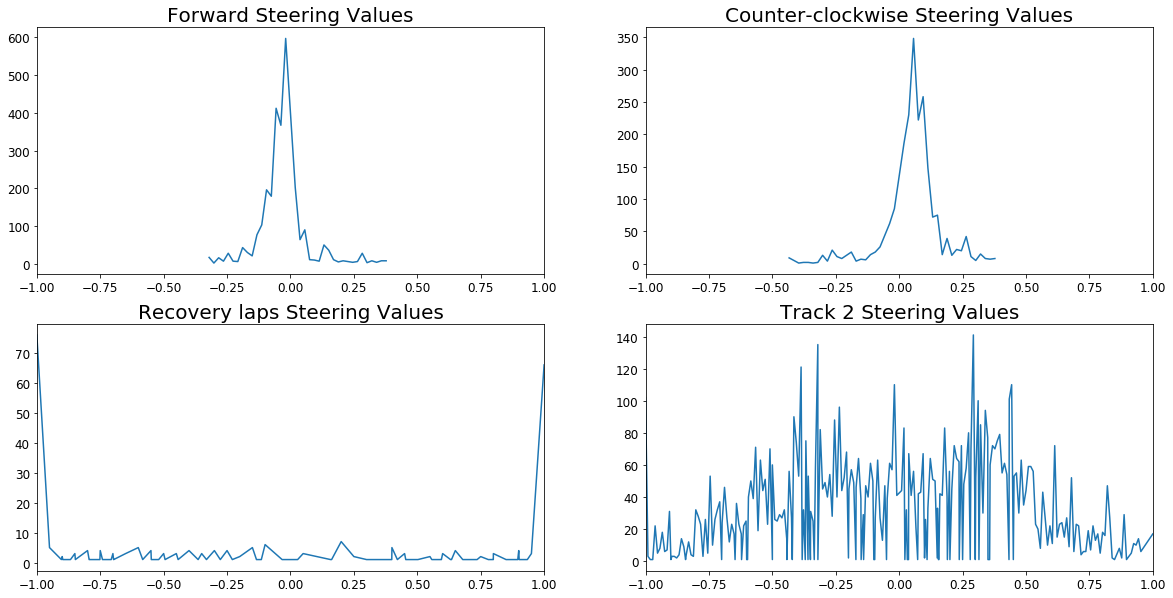

In [14]:
uniq_forward = np.unique(df_forward[df_forward['steering']!= 0]['steering'], return_counts=True)
uniq_reverse = np.unique(df_reverse[df_reverse['steering']!= 0]['steering'], return_counts=True)
uniq_recovering = np.unique(df_recovering[df_recovering['steering']!= 0]['steering'], return_counts=True)
uniq_track2 = np.unique(df_track2[df_track2['steering']!= 0]['steering'], return_counts=True)

fig = plt.figure(figsize=(20,10))

forw = fig.add_subplot(2,2,1)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(-1.0,1.0)
plt.title('Forward Steering Values',fontsize=20)
plt.plot(uniq_forward[0],uniq_forward[1])

reve = fig.add_subplot(2,2,2)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(-1.0,1.0)
plt.title('Counter-clockwise Steering Values',fontsize=20)
plt.plot(uniq_reverse[0],uniq_reverse[1])

reco = fig.add_subplot(2,2,3)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(-1.0,1.0)
plt.title('Recovery laps Steering Values',fontsize=20)
plt.plot(uniq_recovering[0],uniq_recovering[1])


trk2 = fig.add_subplot(2,2,4)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlim(-1.0,1.0)
plt.title('Track 2 Steering Values',fontsize=20)
plt.plot(uniq_track2[0],uniq_track2[1])


plt.show()


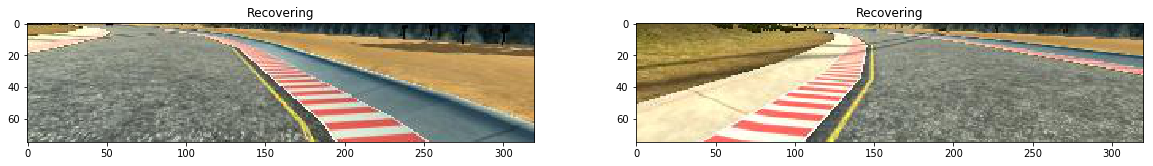

In [44]:
import matplotlib.image as mpimg
from random import randrange

table_center = (table_train[table_train[t][1]==2] for t in table_train) 
track1_forward = extractFilesFromCsv('./records/track1_recovering/driving_log.csv')
img_center = mpimg.imread(table_train[randrange(len(table_train))][0])
img_left= mpimg.imread(track1_forward[0][0])
img_right= mpimg.imread(track1_forward[200][0])


plt.figure(figsize=(20,10))
plt.subplot(121)
plt.title('Recovering')
plt.imshow(img_left[60:135,:])
plt.subplot(122)
plt.title('Recovering')
plt.imshow(img_right[60:135,:])
plt.show()




In [ ]:
### Model with only one simple node
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
import matplotlib.pyplot as plt
import math


model = Sequential()
# Normalization
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

model.add(Flatten(input_shape=(160,320,3)))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')
#history_object = model.fit(X_train, y_train, validation_split=0.2, shuffle=True, nb_epoch=7, verbose=1)
history_object = model.fit_generator(train_generator, samples_per_epoch=samples_per_epoch,  validation_data=valid_generator, nb_val_samples=nb_val_samples, nb_epoch=10)

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model_simple.h5')


In [ ]:
### Model LeNet

from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt

model = Sequential()
# Normalization
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))

model.add(Crooping2D(cropping=((60,25),(0,0))))

model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Convolution2D(6,5,5,activation="relu"))
model.add(MaxPooling2D())
model.add(Flatten())
model.add(Dense(120))
model.add(Dense(84))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam', metrics=['accuracy'])
history_object = model.fit_generator(train_generator, samples_per_epoch=samples_per_epoch,  validation_data=valid_generator, nb_val_samples=nb_val_samples, nb_epoch=10)

### plot the training and validation loss for each epoch
plt.plot(history_object.history['loss'])
plt.plot(history_object.history['val_loss'])
plt.title('model mean squared error loss')
plt.ylabel('mean squared error loss')
plt.xlabel('epoch')
plt.legend(['training set', 'validation set'], loc='upper right')
plt.show()

model.save('model_lenet.h5')


In [ ]:
### Model NVIDIA
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Activation, Dropout
from keras.layers.convolutional import Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping

model = Sequential()
# Normalization
model.add(Lambda(lambda x: (x / 255.0) - 0.5, input_shape=(160,320,3)))
model.add(Cropping2D(cropping=((60,25),(0,0))))
model.add(Convolution2D(24,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(36,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(48,5,5,subsample=(2,2),activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Convolution2D(64,3,3,activation="relu"))
model.add(Flatten())
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

model.summary()

model.compile(loss='mse', optimizer='adam')

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss',patience=3,mode='auto')


history_object = model.fit_generator(train_generator, samples_per_epoch=samples_per_epoch,  validation_data=valid_generator, nb_val_samples=nb_val_samples, nb_epoch=20, callbacks=[early_stopping])
model.save('model.h5')
